<a href="https://colab.research.google.com/github/manitprats/Time-Series-Forecasting/blob/main/ARIMA_Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


"""

Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

Stat library: https://www.statsmodels.org/stable/index.html
Need version 0.11 or later..
pip install statsmodels --upgrade

For pmdarima:
pip install pmdarima
"""---



In [8]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('dark_background')

Month          object
#Passengers     int64
dtype: object
Month          datetime64[ns]
#Passengers             int64
dtype: object


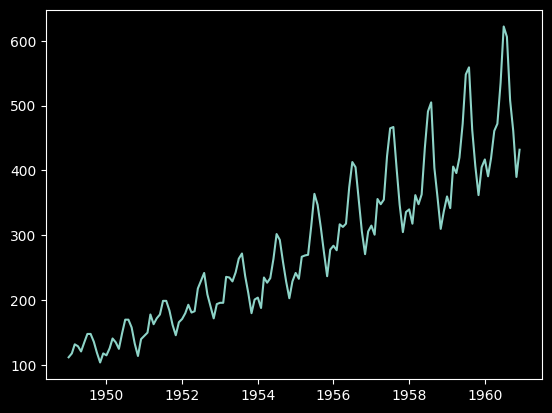

In [4]:
# load the dataset
df = pd.read_csv('/content/drive/MyDrive/Data/AirPassengers.csv')
print(df.dtypes)

df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

df.set_index('Month', inplace=True) 

plt.plot(df['#Passengers'])

In [9]:
#Is the data stationary?
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)
#Not stationary...

(0.01, False)

In [10]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [11]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['#Passengers'],  
                            model ='additive')

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

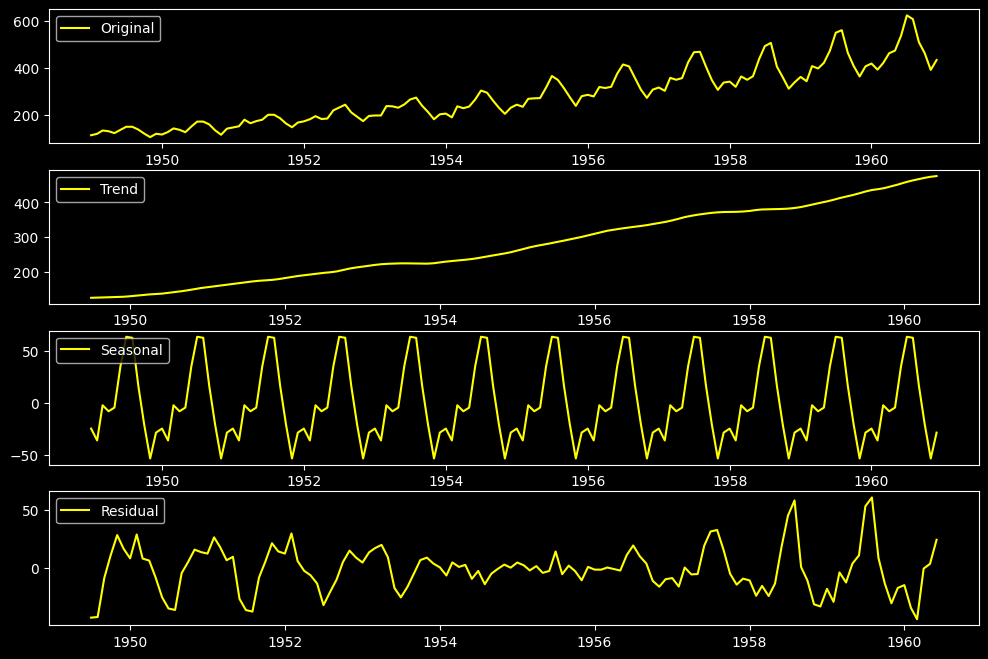

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

In [14]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['#Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)   

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.59 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=1.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.59 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=7.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.29 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.56 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.70 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [15]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 26 May 2023   AIC                           1019.178
Time:                                     21:24:18   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [16]:
#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

In [18]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['#Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Fri, 26 May 2023   AIC                            610.537
Time:                                    21:26:13   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.368
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3201      0.103     -3.103      0.002      -0.522      -0.118
ar.S.L12       0.6847      0.609      1.124      0.261      -0.509       1.878
ar.S.L24       0.3142      0.125      2.520      0.012       0.070       0.559
ma.S.L12      -0.9812      5.431     -0.181      0.857     -11.626       9.664
sigma2        78.6460    379.218      0.207      0.836    -664.607     821.899
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

<Axes: xlabel='Month'>

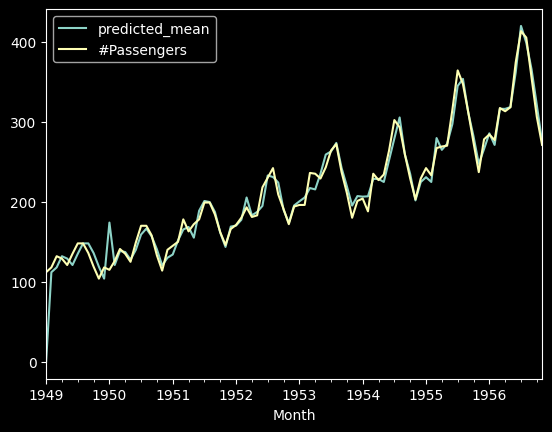

In [28]:
# plot predictions and actual values 
train_prediction.plot(legend = True) 
X_train['#Passengers'].plot(legend = True) 

In [21]:
#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') 
#Rename the column

<Axes: xlabel='Month'>

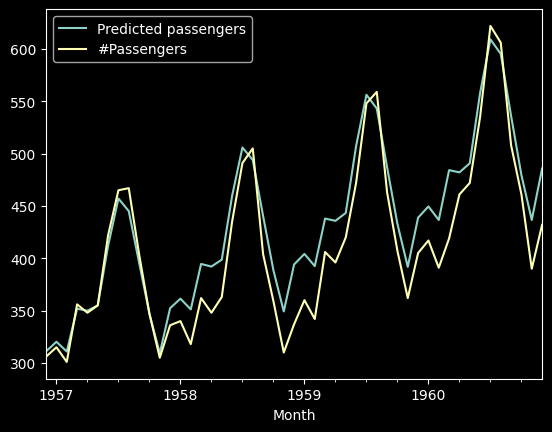

In [22]:
# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['#Passengers'].plot(legend = True) 


In [23]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 16.14 RMSE
Test Score: 29.49 RMSE


In [24]:
#from sklearn.metrics import r2_score
#score = r2_score(X_test, prediction)
#print("R2 score is: ", score)

#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 


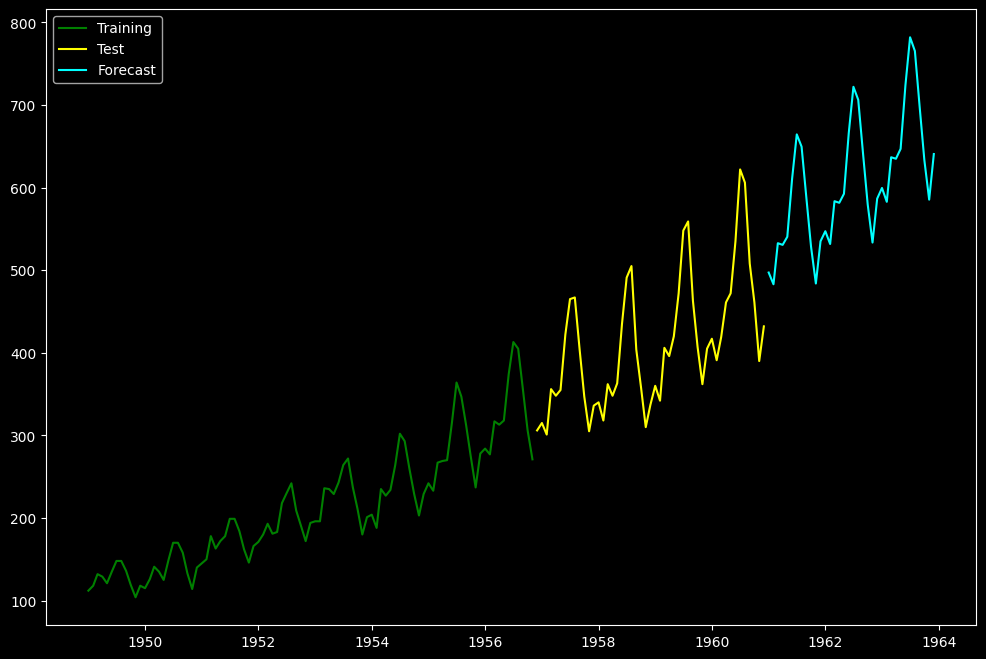

In [27]:
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='best')
plt.show()